# Imports

In [22]:

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms.functional as TF
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from time import perf_counter
import torch.nn.functional as F
from fastdepth_model import MobileNetSkipAdd
from dataset import NYUDepthDataset
import time 
import numpy as np

# Globals

In [23]:
#configuration dictionary
CONFIG = {
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "TRAIN_DIR": "nyu_data/data/nyu2_train",
    "TEST_DIR": "nyu_data/data/nyu2_test",
    "LEARNING_RATE": 1e-3, 
    "BATCH_SIZE": 16,
    "EPOCHS": 20,
    "IMG_WIDTH": 320,
    "IMG_HEIGHT": 240,
    "MAX_DEPTH_METERS": 10.0,
    "ENABLE_SELECTIVITY": False, #change if you want to enable/disable selectivity training
    "SELECTIVITY_LAYER_NAME": "decoder.ups_block_3",#choose the layer to apply selectivity
    "SELECTIVITY_LAMBDA": 0.1,#weight of the selectivity loss
    "NUM_DEPTH_BINS": 27,# number of depth bins for selectivity
    "RESUME_CHECKPOINT": None,#checkpoint path to resume training, none to start from the beginning
}
if CONFIG["ENABLE_SELECTIVITY"]:
    CONFIG["MODEL_SUFFIX"] = "_interpretable"
else:
    CONFIG["MODEL_SUFFIX"] = "_baseline" 

CONFIG["BEST_MODEL_PATH"] = f"models/best_model_meta{CONFIG['MODEL_SUFFIX']}.pth"
CONFIG["LATEST_CHECKPOINT_PATH"] = f"checkpoint/latest_checkpoint{CONFIG['MODEL_SUFFIX']}.pth"
CONFIG["RESUME_CHECKPOINT"] = None

print(f"Device in use: {CONFIG['DEVICE']}")
print(f"Training with selectivity: {'Enabled' if CONFIG['ENABLE_SELECTIVITY'] else 'Disabled'}")
if CONFIG['ENABLE_SELECTIVITY']:
    print(f"Layer Target: {CONFIG['SELECTIVITY_LAYER_NAME']}")
    print(f"Lambda: {CONFIG['SELECTIVITY_LAMBDA']}")
    print(f"Num Bin: {CONFIG['NUM_DEPTH_BINS']}")
print(f"Best model to save in: {CONFIG['BEST_MODEL_PATH']}")
print(f"Last checkpoint: {CONFIG['LATEST_CHECKPOINT_PATH']}")

Device in use: cuda
Training with selectivity: Disabled
Best model to save in: models/best_model_meta_baseline.pth
Last checkpoint: checkpoint/latest_checkpoint_baseline.pth


# Utils

In [24]:

#function to discretize the depth range in a logarithmic way
def discretize_depth(depth, num_bins, max_depth, min_depth=0.1): 
    mask = (depth > min_depth) & (depth < max_depth)#mask for valid values
    bins = torch.full_like(depth, -1, dtype=torch.long)#initialize bins with -1
    
    depth_log = torch.log(depth[mask])# convert to log space
    min_log = torch.log(torch.tensor(min_depth, device=depth.device))
    max_log = torch.log(torch.tensor(max_depth, device=depth.device))
    
    normalized_depth = (depth_log - min_log) / (max_log - min_log)# normalize from 0 to 1
    bin_values = torch.floor(normalized_depth * num_bins).long()# multiply by num bins and floor to get bin index
    
    bins[mask] = torch.clamp(bin_values, 0, num_bins - 1)# insert valid bins into the output tensor
    return bins

#function to capture the activations
activations_capture = {} #dictionary to store the activations
def get_activation(name):
    def hook(model, input, output):
        activations_capture[name] = output #take the output of the layer
    return hook


## Calculate valid bins

In [ ]:
train_dir = CONFIG['TRAIN_DIR'] 
depth_files = sorted(glob.glob(os.path.join(train_dir, '**', '*.png'), recursive=True))
num_bins = CONFIG['NUM_DEPTH_BINS']
max_depth = CONFIG['MAX_DEPTH_METERS']
pixel_counts_np = np.zeros(num_bins, dtype=np.int64)# inizialize pixel counts array

for depth_path in tqdm(depth_files, desc="Count pixels in bins"):
    with Image.open(depth_path) as depth_pil:# open the depth map
        depth_array_raw = np.array(depth_pil)# convert the depth map to numpy array
        
        if depth_array_raw.max() <= 255:#handle 8 and 16 bit images
            depth_meters = depth_array_raw.astype(np.float32) / 255.0 * max_depth
        else:
            depth_meters = depth_array_raw.astype(np.float32) / 1000.0
        
        depth_tensor = torch.from_numpy(depth_meters) # convert to tensor
        gt_bins = discretize_depth(depth_tensor, num_bins, max_depth).numpy() #discretize the depth map
        
        valid_bins = gt_bins[gt_bins != -1]#remove invalid bins
        
        if valid_bins.size > 0: #if there are valid bins
            bin_counts_batch = np.bincount(valid_bins, minlength=num_bins)# count pixels per bin
            pixel_counts_np += bin_counts_batch# update global pixel counts

pixel_counts = torch.from_numpy(pixel_counts_np)# convert to tensor
valid_bin_ids = torch.where(pixel_counts > 0)[0].to(CONFIG['DEVICE'])#get indices of valid bins
print(f"\nValid bins: {valid_bin_ids.tolist()}")
if len(valid_bin_ids) == 0:
    raise ValueError("No depth bins found")

#function to assign depth to units
def assign_depths_to_units(num_units, valid_bins):
    num_valid_bins = len(valid_bins)#count valid bins
    if num_valid_bins == 0:
        return torch.full((num_units,), -1, dtype=torch.long, device=valid_bins.device)
    assign_ids = torch.floor( torch.arange(num_units, device=valid_bins.device) * (num_valid_bins / num_units)).long()# genrate assignment indices
    assign_ids = torch.clamp(assign_ids, 0, num_valid_bins - 1) #clamp to valid range
    return valid_bins[assign_ids] #map the assigned indices to valid bins

## Define Selectivity Loss

In [ ]:
class SelectivityLoss(nn.Module):
    def __init__(self, num_units, num_bins, valid_bins):
        super().__init__()
        self.num_units = num_units #num of units in the layer
        self.num_bins_config = num_bins 
        
        assigned_depths = assign_depths_to_units(num_units, valid_bins)#assign depths to units
        self.register_buffer('assigned_depths', assigned_depths)# register as buffer

    def forward(self, activations, gt_depths, max_depth, min_depth=0.1):
        device = activations.device
        batch_size, num_units, _, _ = activations.shape #get the batch size and num of units of the layer

        gt_bins = discretize_depth(gt_depths, self.num_bins_config, max_depth, min_depth)#discretize ground truth depths
        
        if activations.shape[-2:] != gt_depths.shape[-2:]: #resize depth activations if needed
            activations_resized = F.interpolate(activations, size=gt_depths.shape[-2:], mode='bilinear', align_corners=False)
        else:
            activations_resized = activations

        abs_activations = torch.abs(activations_resized)# take absolute value of activations
        
        avg_responses_batch = torch.zeros(batch_size, num_units, self.num_bins_config, device=device) #inizialize a tensor to store average responses
        
        for d in range(self.num_bins_config):
            mask = (gt_bins == d).float() #mask for current bin
            pixel_counts = torch.sum(mask, dim=[1, 2, 3]) + 1e-8 #count valid pixels per image
            sum_activations = torch.sum(abs_activations * mask, dim=[2, 3])# sum activations for the current bin
            avg_responses_batch[:, :, d] = sum_activations / pixel_counts.unsqueeze(1)# insert average responses for the current bin

        total_loss = 0.0
        data_units = 0

        new_num_bins = avg_responses_batch.shape[2]# get the actual number of bins in the tensor

        for i in range(self.num_units):
            bin_i = self.assigned_depths[i].item()#get the assigned bin for the current unit
            
            if bin_i >= new_num_bins: #if the assigned bin is out of range
                print(f"Jump the unit {i} because its assigned bin ({bin_i}) is out of range "
                      f"from the tensor with dimension: {new_num_bins}).")
                continue 

            r_bin_i = avg_responses_batch[:, i, bin_i] #extract the response for the assigned bin

            other_bins_mask = torch.ones(new_num_bins, dtype=bool, device=device)# mask for other bins
            other_bins_mask[bin_i] = False # exclude the assigned bin
            
            valid_bins_in_batch = (torch.sum(avg_responses_batch[:, i, other_bins_mask], dim=0) > 0)
            if torch.any(valid_bins_in_batch):
                r_mean = torch.mean(avg_responses_batch[:, i, other_bins_mask][:, valid_bins_in_batch], dim=1)#mean response for other bins
            else:
                r_mean = torch.zeros_like(r_bin_i)

            num = r_bin_i - r_mean
            den = r_bin_i + r_mean + 1e-8
            ds_score = num / den #selectivity score
            loss = -torch.mean(ds_score)#minimize selectivity score
            
            if not torch.isnan(loss):
                total_loss += loss
                data_units += 1

        if data_units == 0:
            return torch.tensor(0.0, device=device)

        return total_loss / data_units

# Data

In [25]:


image_transform = transforms.Compose([
    transforms.Resize((CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

depth_transform = transforms.Compose([
    transforms.Resize((CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH']), interpolation=transforms.InterpolationMode.NEAREST),
])

try:
    #subset for train
    train_dataset = NYUDepthDataset(
        CONFIG['TRAIN_DIR'], 
        max_depth=CONFIG['MAX_DEPTH_METERS'],
        transform=image_transform, 
        depth_transform=depth_transform, 
        train=True, 
        val=False  # Non è validation
    )
    
    # subset for val
    val_dataset = NYUDepthDataset(
        CONFIG['TRAIN_DIR'], 
        max_depth=CONFIG['MAX_DEPTH_METERS'],
        transform=image_transform, 
        depth_transform=depth_transform, 
        train=False, # false for validation
        val=True     # true for iterate over training folder
    )
    
    #test set
    test_dataset = NYUDepthDataset(
        CONFIG['TEST_DIR'], 
        max_depth=CONFIG['MAX_DEPTH_METERS'],
        transform=image_transform, 
        depth_transform=depth_transform, 
        train=False, 
        val=False
    )

    assert len(train_dataset) == len(val_dataset) #check if train and val have the same lenght before split

    #divide indices for train and val
    val_percent = 0.1
    n_total = len(train_dataset)
    n_val = int(n_total * val_percent)
    n_train = n_total - n_val
    
    generator = torch.Generator().manual_seed(19)
    train_ids, val_ids = random_split(range(n_total), [n_train, n_val], generator=generator)

    #create subsets
    train_subset = Subset(train_dataset, train_ids)
    val_subset = Subset(val_dataset, val_ids)

    #create dataloaders
    train_loader = DataLoader(train_subset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=8)
    val_loader = DataLoader(val_subset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=8)

    print(f"Dataset loaded successfully:")
    print(f"Training set:   {len(train_subset)} samples ")
    print(f"Validation set: {len(val_subset)} samples ")
    print(f"Test set:       {len(test_dataset)} samples ")

except (FileNotFoundError, AssertionError, TypeError) as e:
    print(e)

Dataset loaded successfully:
Training set:   45620 samples 
Validation set: 5068 samples 
Test set:       654 samples 


# Network

In [26]:
#region: MobileViT Model Definition
def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU()
    )

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, depth=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels,
                                   kernel_size=kernel_size,
                                   groups=in_channels,
                                   padding=1,
                                   stride=stride,
                                   bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out


def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        SeparableConv2d(in_channels=inp, out_channels=oup, kernel_size=kernal_size, stride=stride, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU()
    )


class ModLayerNorm(nn.GroupNorm):
  def __init__(self, dim):
      super().__init__(1, dim)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = ModLayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.c1 = nn.Conv2d(dim,hidden_dim,1)
        self.act = nn.ReLU()
        self.c2 = nn.Conv2d(hidden_dim,dim,1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.c2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, pool_size):
      super().__init__()
      self.pool = nn.AvgPool2d(pool_size, stride=1, padding=pool_size//2, count_include_pad=False)

    def forward(self, x):
      return self.pool(x) - x


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(3)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class MV2Block(nn.Module):
    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(),
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)

    def forward(self, x):
        y = x.clone()
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.transformer(x)
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x


class MobileViT(nn.Module):
    def __init__(self, image_size, dims, channels, expansion=4, kernel_size=3, patch_size=(2, 2)):
        super().__init__()
        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        L = [1, 1, 1]

        self.conv1 = conv_nxn_bn(3, channels[0], stride=2)

        self.mv2 = nn.ModuleList([])
        self.mv2.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.mv2.append(MV2Block(channels[1], channels[2], 2, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.mv2.append(MV2Block(channels[3], channels[4], 2, expansion))
        self.mv2.append(MV2Block(channels[5], channels[6], 2, expansion))
        self.mv2.append(MV2Block(channels[7], channels[8], 2, expansion))

        self.mvit = nn.ModuleList([])
        self.mvit.append(MobileViTBlock(dims[0], L[0], channels[5], kernel_size, patch_size, int(dims[0] * 2)))
        self.mvit.append(MobileViTBlock(dims[1], L[1], channels[7], kernel_size, patch_size, int(dims[1] * 4)))
        self.mvit.append(MobileViTBlock(dims[2], L[2], channels[9], kernel_size, patch_size, int(dims[2] * 4)))

        self.conv2 = conv_1x1_bn(channels[-2], channels[-1])

    def forward(self, x):
        y0 = self.conv1(x)
        x = self.mv2[0](y0)
        y1 = self.mv2[1](x)
        x = self.mv2[2](y1)
        x = self.mv2[3](x)
        y2 = self.mv2[4](x)
        x = self.mvit[0](y2)
        y3 = self.mv2[5](x)
        x = self.mvit[1](y3)
        x = self.mv2[6](x)
        x = self.mvit[2](x)
        x = self.conv2(x)

        return x, [y0, y1, y2, y3]

def mobilevit_xxs(transformer_times, sample_cnt): 
    enc_type = 'xxs'
    dims = [64, 80, 96]
    channels = [16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 160]  # 320
    return MobileViT((CONFIG["IMG_HEIGHT"],  CONFIG["IMG_WIDTH"]), dims, channels), enc_type 


def mobilevit_xs(transformer_times, sample_cnt):
    enc_type = 'xs'
    dims = [96, 120, 144]
    channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 192] # 384
    return MobileViT((CONFIG["IMG_HEIGHT"], CONFIG["IMG_WIDTH"]), dims, channels), enc_type 


def mobilevit_s(transformer_times, sample_cnt): 
    enc_type = 's'
    dims = [144, 192, 240]
    channels = [16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 320]
    return MobileViT((CONFIG["IMG_HEIGHT"],  CONFIG["IMG_WIDTH"]), dims, channels), enc_type 

class UpSample_layer(nn.Module):
    def __init__(self, inp, oup, sep_conv_filters):
        super(UpSample_layer, self).__init__()
        self.conv2d_transpose = nn.ConvTranspose2d(inp, oup, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),
                                                   dilation=1, output_padding=(1, 1), bias=False)
        self.end_up_layer = nn.Sequential(
            SeparableConv2d(sep_conv_filters, oup, kernel_size=(3, 3)),
            nn.ReLU()
        )

    def forward(self, x, enc_layer):
        x = self.conv2d_transpose(x)
        if x.shape[2] != enc_layer.shape[2] or x.shape[3] != enc_layer.shape[3]:
             x = F.interpolate(x, size=(enc_layer.shape[2], enc_layer.shape[3]), mode='bilinear', align_corners=False)
        
        x = torch.cat([x, enc_layer], dim=1)
        x = self.end_up_layer(x)
        return x

class SPEED_decoder(nn.Module):
    def __init__(self, typ):
        super(SPEED_decoder, self).__init__()
        self.conv2d_in = nn.Conv2d(320 if typ == 's' else 192 if typ == 'xs' else 160,
                                   128 if typ == 's' else 128 if typ == 'xs' else 64,
                                   kernel_size=(1, 1), padding='same', bias=False)
        self.ups_block_1 = UpSample_layer(128 if typ == 's' else 128 if typ == 'xs' else 64,
                                          64 if typ == 's' else 64 if typ == 'xs' else 32,
                                          sep_conv_filters=192 if typ == 's' else 144 if typ == 'xs' else 96)
        self.ups_block_2 = UpSample_layer(64 if typ == 's' else 64 if typ == 'xs' else 32,
                                          32 if typ == 's' else 32 if typ == 'xs' else 16,
                                          sep_conv_filters=128 if typ == 's' else 96 if typ == 'xs' else 64)
        self.ups_block_3 = UpSample_layer(32 if typ == 's' else 32 if typ == 'xs' else 16,
                                          16 if typ == 's' else 16 if typ == 'xs' else 8,
                                          sep_conv_filters=80 if typ == 's' else 64 if typ == 'xs' else 32)
        self.final_upsample = nn.ConvTranspose2d(16 if typ == 's' else 16 if typ == 'xs' else 8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        
        self.conv2d_out = nn.Conv2d(1, 1, kernel_size=(3, 3), padding='same', bias=False)


    def forward(self, x, enc_layer_list):
        x = self.conv2d_in(x)
        x = self.ups_block_1(x, enc_layer_list[3])
        x = self.ups_block_2(x, enc_layer_list[2])
        x = self.ups_block_3(x, enc_layer_list[1])
        x = self.final_upsample(x)
        x = self.conv2d_out(x)
        return x


class build_model(nn.Module):
   
    def __init__(self, arch_type):
        super(build_model, self).__init__()
        self.transformer_times = np.zeros((3,655),dtype='float') 
        self.sample_cnt = 0 

        if arch_type == 's':
            self.encoder, enc_type = mobilevit_s(self.transformer_times, self.sample_cnt) 
        elif arch_type == 'xs':
            self.encoder, enc_type = mobilevit_xs(self.transformer_times, self.sample_cnt) 
        else:
            self.encoder, enc_type = mobilevit_xxs(self.transformer_times, self.sample_cnt)
        self.decoder = SPEED_decoder( typ=enc_type)

    def forward(self, x):
        x_enc, enc_layers = self.encoder(x)
        x_dec = self.decoder(x_enc, enc_layers)
        return x_dec
#endregion

In [27]:
# old model
# model = MobileNetSkipAdd(output_size=(224, 224), pretrained=True)
# model.to(CONFIG['DEVICE'])


ARCH_TYPE = 's'
model = build_model(arch_type=ARCH_TYPE)
model.to(CONFIG['DEVICE'])


print("Models names:")
for name, _ in model.named_modules():
    print(name)

print("\nModels architecture:")
print(model)

Models names:

encoder
encoder.conv1
encoder.conv1.0
encoder.conv1.0.depthwise
encoder.conv1.0.pointwise
encoder.conv1.1
encoder.conv1.2
encoder.mv2
encoder.mv2.0
encoder.mv2.0.conv
encoder.mv2.0.conv.0
encoder.mv2.0.conv.1
encoder.mv2.0.conv.2
encoder.mv2.0.conv.3
encoder.mv2.0.conv.4
encoder.mv2.0.conv.5
encoder.mv2.0.conv.6
encoder.mv2.0.conv.7
encoder.mv2.1
encoder.mv2.1.conv
encoder.mv2.1.conv.0
encoder.mv2.1.conv.1
encoder.mv2.1.conv.2
encoder.mv2.1.conv.3
encoder.mv2.1.conv.4
encoder.mv2.1.conv.5
encoder.mv2.1.conv.6
encoder.mv2.1.conv.7
encoder.mv2.2
encoder.mv2.2.conv
encoder.mv2.2.conv.0
encoder.mv2.2.conv.1
encoder.mv2.2.conv.2
encoder.mv2.2.conv.3
encoder.mv2.2.conv.4
encoder.mv2.2.conv.5
encoder.mv2.2.conv.6
encoder.mv2.2.conv.7
encoder.mv2.3
encoder.mv2.3.conv
encoder.mv2.3.conv.0
encoder.mv2.3.conv.1
encoder.mv2.3.conv.2
encoder.mv2.3.conv.3
encoder.mv2.3.conv.4
encoder.mv2.3.conv.5
encoder.mv2.3.conv.6
encoder.mv2.3.conv.7
encoder.mv2.4
encoder.mv2.4.conv
encoder.mv2.4.

## Assign Depths to Units

In [ ]:


try:
    target_layer = dict(model.named_modules())[CONFIG['SELECTIVITY_LAYER_NAME']]# get the target layer
    
    conv_layer = [m for m in target_layer.modules() if isinstance(m, nn.Conv2d)]# find all Conv2d layers in the target module
    if not conv_layer:
        raise ValueError("No layer found")
    layer_units = conv_layer[-1].out_channels#get the output channels of the last Conv2d layer
    
    assign_depths = assign_depths_to_units(layer_units, valid_bin_ids) #assign depths to units
    
    print(f"Assigned {layer_units} units at {len(valid_bin_ids)} valid bins")
 

except Exception as e:
    print(f"\nNo bins assigned: {e}")

# Train

In [ ]:

def train_one_epoch(model, dataloader, optimizer, loss_fn, interpretable_loss_fn, curr_lambda, config):
    model.train()
    total_l1_loss = 0.0
    total_sel_loss = 0.0
    
    pbar = tqdm(dataloader, desc="Training Epoch")
    for images, depths in pbar:
        images, depths = images.to(config['DEVICE']), depths.to(config['DEVICE'])
        optimizer.zero_grad() #zero the gradients of the previous step
        
        pred_depths = model(images) #forward pass
        
        predicted_depths_resized = F.interpolate(pred_depths, size=depths.shape[-2:], mode='bilinear', align_corners=False)# resize to match gt size
        mask = depths > 0 #mask for valid depths
        l1_loss = loss_fn(predicted_depths_resized[mask], depths[mask])# calculate L1 loss

        sel_loss = torch.tensor(0.0, device=config['DEVICE'])
        if curr_lambda > 0 and interpretable_loss_fn is not None:# if selectivity is enabled
            layer_name = config['SELECTIVITY_LAYER_NAME']# get the target layer name
            if layer_name in activations_capture:
                interpretable_activations = activations_capture[layer_name]#take the activations from the hook
                base_sel_loss = interpretable_loss_fn(interpretable_activations, depths, config['MAX_DEPTH_METERS'])
                sel_loss = curr_lambda * base_sel_loss# weight the selectivity loss
        
        total_loss = l1_loss + sel_loss
        if not torch.isnan(total_loss):
            total_loss.backward()# backpropagation
            optimizer.step()# update weights
            total_l1_loss += l1_loss.item()
            total_sel_loss += sel_loss.item()

        pbar.set_postfix(l1_loss=f"{l1_loss.item():.4f}", sel_loss=f"{sel_loss.item():.4f}")
    
    return total_l1_loss / len(dataloader), total_sel_loss / len(dataloader)

def validate_one_epoch(model, dataloader, loss_fn, device, desc="Validating"):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, depths in tqdm(dataloader, desc=desc):
            images, depths = images.to(device), depths.to(device)
            predicted_depths = model(images)
            predicted_depths = F.interpolate(predicted_depths, size=depths.shape[-2:], mode='bilinear', align_corners=False)
            mask = depths > 0
            loss = loss_fn(predicted_depths[mask], depths[mask])# calculate L1 loss on valid set
            if not torch.isnan(loss):
                total_loss += loss.item()
    return total_loss / len(dataloader)

loss_fn = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['LEARNING_RATE'])
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

interpretable_loss_fn = None
hook_handle = None

if CONFIG['ENABLE_SELECTIVITY']:
    try:
        target_layer_module = dict(model.named_modules())[CONFIG['SELECTIVITY_LAYER_NAME']]
        
        conv_layers = [m for m in target_layer_module.modules() if isinstance(m, nn.Conv2d)]
        if not conv_layers:
            raise ValueError(f"No Conv2d layers found in the target module '{CONFIG['SELECTIVITY_LAYER_NAME']}'")
        num_units = conv_layers[-1].out_channels #take the output channels of the last layer
        
        interpretable_loss_fn = SelectivityLoss(# create the loss instance
            num_units=num_units,
            num_bins=CONFIG['NUM_DEPTH_BINS'],
            valid_bins=valid_bin_ids
        ).to(CONFIG['DEVICE'])
        
        target_layer = dict(model.named_modules())[CONFIG['SELECTIVITY_LAYER_NAME']]
        hook_handle = target_layer.register_forward_hook(get_activation(CONFIG['SELECTIVITY_LAYER_NAME']))#take the activation with a hook and save into the dictionary activation capture

    except (KeyError, AttributeError, NameError) as e:
        print(f"Error in the setup of the loss: {e}")
        raise

start_epoch = 0
best_val_loss = float('inf')
if CONFIG.get('RESUME_CHECKPOINT') and os.path.exists(CONFIG['RESUME_CHECKPOINT']):#if wantt to resume a training
    print(f"Resume training from {CONFIG['RESUME_CHECKPOINT']}")
    checkpoint = torch.load(CONFIG['RESUME_CHECKPOINT'], map_location=CONFIG['DEVICE'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Checkpoint loaded {start_epoch}, best_val_loss = {best_val_loss:.4f}")
else:
    print("Start a new training")

for epoch in range(start_epoch, CONFIG['EPOCHS']):#loop over epochs
    print(f"\n--- Epoch [{epoch+1}/{CONFIG['EPOCHS']}] ---")
    
    current_lambda = 0.0
    if CONFIG['ENABLE_SELECTIVITY']:
        current_lambda = CONFIG['SELECTIVITY_LAMBDA']

    avg_l1_loss, avg_sel_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, interpretable_loss_fn, current_lambda, CONFIG)
    
    avg_val_loss = validate_one_epoch(model, val_loader, loss_fn, CONFIG['DEVICE'])
    scheduler.step()
    
    print(f"Epoch [{epoch+1}/{CONFIG['EPOCHS']}], Avg L1 Loss: {avg_l1_loss:.4f}, Avg Sel Loss: {avg_sel_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({'model_state_dict': model.state_dict()}, CONFIG['BEST_MODEL_PATH'])# save best model based on val loss
        print(f"New best model saved in '{CONFIG['BEST_MODEL_PATH']}' (Val Loss: {best_val_loss:.4f})")
        
    latest_checkpoint = {#save latest checkpoint
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss
    }
    torch.save(latest_checkpoint, CONFIG['LATEST_CHECKPOINT_PATH'])

if hook_handle:
    hook_handle.remove()# remove the hook

print("\nTraining completed")

# Evaluation

## Load best model or checkpoint path

In [28]:
#checkpoint = torch.load(CONFIG['LATEST_CHECKPOINT_PATH'], map_location=CONFIG['DEVICE'])
#model.load_state_dict(checkpoint['model_state_dict'])
checkpoint = torch.load(CONFIG['LATEST_CHECKPOINT_PATH'], map_location=CONFIG['DEVICE'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(CONFIG['DEVICE'])


build_model(
  (encoder): MobileViT(
    (conv1): Sequential(
      (0): SeparableConv2d(
        (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
        (pointwise): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (mv2): ModuleList(
      (0): MV2Block(
        (conv): Sequential(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
          (6): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (7): BatchNorm2d(32, eps

## Evaluate depth performance

In [ ]:
#function to evaluate depth performance metrics
def evaluate_performance(model, dataloader, device):
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for images, gt_depths in tqdm(dataloader, desc="Evaluating Performance"):
            images, gt_depths_gpu = images.to(device), gt_depths.to(device)
            pred_depths = model(images)#obtain predictions
            pred_depths = F.interpolate(pred_depths, size=gt_depths_gpu.shape[-2:], mode='bilinear', align_corners=False)#resize
            
            mask = gt_depths_gpu > 0#mask for valid depths
            valid_preds = pred_depths[mask].cpu()
            valid_gts = gt_depths_gpu[mask].cpu()
            preds.append(valid_preds)
            gts.append(valid_gts)

    preds = torch.cat(preds).numpy()
    gts = torch.cat(gts).numpy()
    
    #calculate the metrics
    abs_diff = np.abs(gts - preds)
    mae = np.mean(abs_diff)
    rmse = np.sqrt(np.mean((gts - preds) ** 2))
    abs_rel = np.mean(abs_diff / gts)
    
    #calculate delta metrics
    ratio = np.maximum((gts / preds), (preds / gts))
    delta1 = (ratio < 1.25).mean()
    delta2 = (ratio < 1.25**2).mean()
    delta3 = (ratio < 1.25**3).mean()
    
    results = {
        "rmse": rmse, "mae": mae, "rel": abs_rel,
        "delta1": delta1, "delta2": delta2, "delta3": delta3
    }
    return results

print(f"\nModel loaded:'{CONFIG['BEST_MODEL_PATH']}'")


performance_metrics = evaluate_performance(model, test_loader, CONFIG['DEVICE'])#call the evaluation function


print("\n Performance on Test Set:")
print(f"RMSE:{performance_metrics['rmse']:.4f}")
print(f"MAE: {performance_metrics['mae']:.4f}")
print(f"REL: {performance_metrics['rel']:.4f}")

print(f"δ < 1.25: {performance_metrics['delta1']:.4%}")
print(f"δ < 1.25²: {performance_metrics['delta2']:.4%}")
print(f"δ < 1.25³: {performance_metrics['delta3']:.4%}")

# function to visulize depth predictions
def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    samples_shown = 0
    with torch.no_grad():
        for images, gt_depths in dataloader:
            images = images.to(device)
            predicted_depths = model(images).cpu()
            
            for i in range(images.size(0)):
                if samples_shown >= num_samples: return

                img = images[i].cpu().permute(1, 2, 0).numpy()#convert the dimension for matplotlib
                mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])# denormalize
                img = np.clip(std * img + mean, 0, 1)

                gt = gt_depths[i].squeeze().numpy()#convert depth and prediction to numpy
                pred = predicted_depths[i].squeeze().numpy()
                
                #plot the images gt and prediction
                fig, axes = plt.subplots(1, 3, figsize=(18, 6))
                axes[0].imshow(img); axes[0].set_title("RGB image"); axes[0].axis('off')
                axes[1].imshow(gt, cmap='magma', vmin=0, vmax=CONFIG['MAX_DEPTH_METERS']); axes[1].set_title("Ground Truth"); axes[1].axis('off')
                im = axes[2].imshow(pred, cmap='magma', vmin=0, vmax=CONFIG['MAX_DEPTH_METERS']); axes[2].set_title("Prediction"); axes[2].axis('off')
                fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
                plt.show()
                samples_shown += 1

visualize_predictions(model, test_loader, CONFIG['DEVICE'])

## Selectivity evaluation

### Neuron selectivity

In [ ]:
#function to visualzie the selectivity of the neuron

def visualize_neuron_selectivity(model, dataloader, layer_name, config, valid_bin_ids, num_units_to_show=32, num_batches=50):
   
    model.eval()
    device = config['DEVICE']
    num_bins = config['NUM_DEPTH_BINS']
    max_depth = config['MAX_DEPTH_METERS']
    
    hook_handle = None
    avg_responses = None 
    num_units = 0

    try:
        target_layer = dict(model.named_modules())[layer_name]
        num_units = [m.out_channels for m in target_layer.modules() if isinstance(m, nn.Conv2d)][-1]
        hook_handle = target_layer.register_forward_hook(get_activation(layer_name))
        
        sum_responses = torch.zeros(num_units, num_bins, device=device)
        pixel_counts = torch.zeros(num_units, num_bins, device=device)
        
        with torch.no_grad():
            pbar = tqdm(total=min(num_batches, len(dataloader)), desc="Calculating Selectivity")
            for i, (images, gt_depths) in enumerate(dataloader):
                if i >= num_batches: break
                images, gt_depths = images.to(device), gt_depths.to(device)
                _ = model(images)# forward pass to capture activations
                
                activations = activations_capture[layer_name]# get the activations from the hook
                activations_resized = F.interpolate(activations, size=gt_depths.shape[-2:], mode='bilinear', align_corners=False)
                gt_bins = discretize_depth(gt_depths, num_bins, max_depth)
                abs_activations = torch.abs(activations_resized)# take absolute value of the activations
                
                for k in range(num_units):
                    for d in range(num_bins):
                        mask_d = (gt_bins == d).float()#mask for the current bin
                        sum_responses[k, d] += torch.sum(abs_activations[:, k, :, :] * mask_d)#sum the activations for the current bin
                        pixel_counts[k, d] += torch.sum(mask_d)# count valid pixels for the current bin
                pbar.update(1)
            pbar.close()

        avg_responses = (sum_responses / (pixel_counts + 1e-8)).cpu().numpy()# calculate average responses

    except (KeyError, AttributeError, IndexError) as e:
        print(f"error in visualization: {e}")
        return 

    finally:
        if hook_handle:
            hook_handle.remove()

    if avg_responses is None:
        return

    indices_to_show = np.linspace(0, num_units - 1, min(num_units_to_show, num_units), dtype=int)#select units to show
    assigned_depths_map = None
    if config.get("ENABLE_SELECTIVITY", False):
        assigned_depths_tensor = assign_depths_to_units(num_units, valid_bin_ids.cpu())#assign target bin
        assigned_depths_map = assigned_depths_tensor.numpy()
        
    print(f"Visualize the units: {indices_to_show}")
    

    fig, axes = plt.subplots(1, len(indices_to_show), figsize=(5 * len(indices_to_show), 4), sharey=True)
    fig.suptitle(f"Avg response of the layer'{layer_name}'at every depth bin", fontsize=16)
    
    #calculate the depth values
    log_min = np.log(0.1) 
    log_max = np.log(max_depth)
    log_bin_edges = np.linspace(log_min, log_max, num_bins + 1)
    depth_bin_values = np.exp(log_bin_edges[:-1]) #use the beginning of each bin as representative value
    x_positions = np.arange(num_bins) #x axe is the number or bin

    for i, unit_idx in enumerate(indices_to_show):
        ax = axes if len(indices_to_show) == 1 else axes[i]#iterate over the units
        responses = avg_responses[unit_idx]
        ax.bar(x_positions, responses, width=0.8) #height of the bar is the average response
        
        title = f"Unit {unit_idx}"
        if assigned_depths_map is not None:# if selectivity is enabled
            assigned_bin = assigned_depths_map[unit_idx]#obtain the assigned bin
            assigned_depth_val = depth_bin_values[assigned_bin]
            title += f"\n(Target Bin: {assigned_bin} ≈ {assigned_depth_val:.1f}m)"
            if assigned_bin < len(ax.patches):
                 ax.patches[assigned_bin].set_facecolor('orangered')
        ax.set_title(title)
        ax.set_xlabel("Depth (m)")

        num_labels = 5  
        tick_indices = np.linspace(0, num_bins - 1, num_labels, dtype=int)#linear ticks
        tick_labels = [f"{depth_bin_values[idx]:.1f}" for idx in tick_indices]
        ax.set_xticks(tick_indices)
        ax.set_xticklabels(tick_labels)

        if i == 0:
            ax.set_ylabel("Avg response")
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


visualize_neuron_selectivity(model, train_loader, CONFIG['SELECTIVITY_LAYER_NAME'], CONFIG, valid_bin_ids)



### Visualize activation map

In [ ]:

#function to show activation maps
def visualize_activation_maps(model, dataloader, layer_name, config, valid_bin_ids, num_images=3, image_idx=None, units_to_show=[1, 7, 13]):

    model.eval()
    device = config['DEVICE']
    hook_handle = None

    try:
        target_layer = dict(model.named_modules())[layer_name]
        hook_handle = target_layer.register_forward_hook(get_activation(layer_name))
        num_units = [m.out_channels for m in target_layer.modules() if isinstance(m, nn.Conv2d)][-1]
        
        assigned_targets = assign_depths_to_units(num_units, valid_bin_ids.cpu())
        log_min = np.log(0.1)
        log_max = np.log(config['MAX_DEPTH_METERS'])
        log_bin_edges = np.linspace(log_min, log_max, config['NUM_DEPTH_BINS'] + 1)
        log_bin_centers = (log_bin_edges[:-1] + log_bin_edges[1:]) / 2
        depth_bin_centers = np.exp(log_bin_centers)

        print(f"Visualize units: {units_to_show}")
        
        images_shown = 0
        curr_idx = 0
        with torch.no_grad():
            for images, gt_depths in dataloader:#iterate over batches
                for i in range(images.size(0)):
                    show = False
                    if image_idx is not None:
                        if curr_idx == image_idx:
                            show = True
                    elif images_shown < num_images:
                        show = True

                    if show:
                        print(f"\nVisualize image number {curr_idx}")
                        
                        image_tensor = images[i].unsqueeze(0).to(device)
                        
                        _ = model(image_tensor)
                        activations = activations_capture[layer_name]

                        #plot the image gt depth and feature maps
                        img_rgb_normalized = images[i].permute(1, 2, 0).numpy()
                        mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
                        img_rgb = np.clip(std * img_rgb_normalized + mean, 0, 1)
                        
                        gt_depth = gt_depths[i].squeeze().numpy()
                        
                        num_plots = 2 + len(units_to_show)
                        fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6))
                        
                        axes[0].imshow(img_rgb)
                        axes[0].set_title("Image RGB")
                        axes[0].axis('off')

                        axes[1].imshow(gt_depth, cmap='magma', vmin=0, vmax=config['MAX_DEPTH_METERS'])
                        axes[1].set_title("Depth (m) ")
                        axes[1].axis('off')
                        
                        for j, unit_idx in enumerate(units_to_show):
                            activation_map = torch.abs(activations[0, unit_idx, :, :]).cpu().numpy()
                            
                            h, w, _ = img_rgb.shape
                            activation_map_resized = cv2.resize(activation_map, (w, h))
                            
                            heatmap = cv2.normalize(activation_map_resized, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
                            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
                            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
                            
                            img_with_heatmap = cv2.addWeighted((img_rgb * 255).astype(np.uint8), 0.5, heatmap, 0.5, 0)
                            
                            ax = axes[2 + j]
                            ax.imshow(img_with_heatmap)
                            target_bin = assigned_targets[unit_idx].item()
                            target_depth = depth_bin_centers[target_bin]
                            ax.set_title(f"Unit{unit_idx}\n(Target: Bin {target_bin} ≈ {target_depth:.1f}m)")
                            ax.axis('off')

                        plt.tight_layout()
                        plt.show()
                        
                        images_shown += 1

                    
                    curr_idx += 1
                    
                    if (image_idx is not None and images_shown > 0) or \
                       (image_idx is None and images_shown >= num_images):
                        break
                
                if (image_idx is not None and images_shown > 0) or \
                   (image_idx is None and images_shown >= num_images):
                    break
            
    except (KeyError, IndexError, AttributeError) as e:
        print(f"error: {e}")
        return
    finally:
        if hook_handle:
            hook_handle.remove()


visualize_activation_maps(model, test_loader, CONFIG['SELECTIVITY_LAYER_NAME'], CONFIG, valid_bin_ids)


### Evaluate selectivity metrics

In [ ]:


def evaluate_selectivity(model, dataloader, layer_name, config, valid_bin_ids):
    model.eval()
    device = config['DEVICE']
    num_bins = config['NUM_DEPTH_BINS']
    max_depth = config['MAX_DEPTH_METERS']
    
    hook_handle = None
    try:
    
        target_layer = dict(model.named_modules())[layer_name]
        hook_handle = target_layer.register_forward_hook(get_activation(layer_name))
        num_units = [m.out_channels for m in target_layer.modules() if isinstance(m, nn.Conv2d)][-1]
        
        sum_responses = torch.zeros(num_units, num_bins, device=device)
        pixel_counts = torch.zeros(num_bins, device=device)

        print(f"Calculate selectivity for '{layer_name}' with ({num_units} units")
        with torch.no_grad():
            for images, gt_depths in tqdm(dataloader, desc="Calculating Selectivity"):
                images, gt_depths = images.to(device), gt_depths.to(device)
                _ = model(images) 
                
                activations = activations_capture[layer_name]# get the activations from the hook
                activations_resized = F.interpolate(activations, size=gt_depths.shape[-2:], mode='bilinear', align_corners=False)
                gt_bins = discretize_depth(gt_depths, num_bins, max_depth)
                abs_activations = torch.abs(activations_resized)
                
                for d in range(num_bins):
                    mask_d = (gt_bins == d)#mask for the current bin
                    sum_responses[:, d] += torch.sum(abs_activations * mask_d.float(), dim=(0, 2, 3))#sum activations for the current bin
                    pixel_counts[d] += torch.sum(mask_d)# count valid pixels for the current bin
        
        avg_responses = sum_responses / (pixel_counts.unsqueeze(0) + 1e-8)
    
        assigned_targets = assign_depths_to_units(num_units, valid_bin_ids.to(device))# assign target bins to units
        
        ds_scores, ds_scores_target = [], []#list to store the ds scores
        correct_assignments = 0# counter for correct assignments
        count_non_active_units = 0
        for k in range(num_units):
            responses_k = avg_responses[k]
            target_bin = assigned_targets[k].item()
            if torch.all(responses_k == 0): 
                count_non_active_units += 1
                continue#skip if no response in any bin
            
            R_max_val, R_max_idx = torch.max(responses_k), torch.argmax(responses_k)#find the max response and its index
            other_mask = torch.ones(num_bins, dtype=bool, device=device); other_mask[R_max_idx] = False#mask for other bins
            valid_bins_mask = pixel_counts > 0
            final_mask = other_mask & valid_bins_mask
            R_bar_other = torch.mean(responses_k[final_mask]) if torch.sum(final_mask) > 0 else 0.0#mean response for other bins
            ds_generic = (R_max_val - R_bar_other) / (R_max_val + R_bar_other + 1e-8)#calcuculate the ds score
            ds_scores.append(ds_generic.item())
            
            R_target_val = responses_k[target_bin]# response for the target bin
            other_target_mask = torch.ones(num_bins, dtype=bool, device=device); other_target_mask[target_bin] = False#mean for other bins excluding the target
            final_target_mask = other_target_mask & valid_bins_mask
            R_bar_not_target = torch.mean(responses_k[final_target_mask]) if torch.sum(final_target_mask) > 0 else 0.0
            ds_target = (R_target_val - R_bar_not_target) / (R_target_val + R_bar_not_target + 1e-8)
            ds_scores_target.append(ds_target.item())
            
            if R_max_idx == target_bin:
                correct_assignments += 1#coorect assignment if the max response bin is the target bin
                
        num_valid_units = len(ds_scores) if len(ds_scores) > 0 else 1
        
        results = {
            "avg_ds_score_generic": np.mean(ds_scores) if ds_scores else 0.0,
            "avg_ds_score_target": np.mean(ds_scores_target) if ds_scores_target else 0.0,
            "assignment_accuracy": (correct_assignments / num_valid_units),
            "non_active_units": count_non_active_units
        }
        

        print(f" DS Score: {results['avg_ds_score_generic']:.4f}")
        print(f"Ds score target :{results['avg_ds_score_target']:.4f}")
        print(f"Assigning accuracy {results['assignment_accuracy']:.2%}")
        print(f"Non-active units: {results['non_active_units']} out of {num_units}")
        
        return results

    except (KeyError, AttributeError, IndexError) as e:
        print(f"error {e}")
        return {"avg_ds_score_generic": 0.0, "avg_ds_score_target": 0.0, "assignment_accuracy": 0.0}

    finally:
        if hook_handle:
            hook_handle.remove()

selectivity_metrics = evaluate_selectivity(model, train_loader, CONFIG['SELECTIVITY_LAYER_NAME'], CONFIG, valid_bin_ids)


## Inference Time


In [ ]:
inference_device = 'cpu' #change here for the test
model.to(inference_device)

def inference_time(model, dataloader, device, num_warmup=10, num_test=41):
    model.eval()
    times = []

    print(f"Warmup")
    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i >= num_warmup: 
                break
            images = images.to(device)
            _ = model(images) #ignore the output

    print(f"Start test on {num_test} samples")
    with torch.no_grad():
        pbar = tqdm(total = num_test, desc="Measuring Inference Time")
        batches = 0
        for images, _ in dataloader:
            if batches >= num_test:
                break
            images = images.to(device)

            if device == 'cuda':
                torch.cuda.synchronize()
            start_time = time.perf_counter()

            _ = model(images)

            if device == 'cuda':
                torch.cuda.synchronize()
            end_time = time.perf_counter()

            inference_time = end_time - start_time
            times.append(inference_time / images.size(0))#time per image
            batches += 1
            pbar.update(1)
        pbar.close()

        times_array = np.array(times)

        avg_time_per_image = np.mean(times_array)


        print(f"Device: {device.upper()}")
        print(f"Model: {CONFIG['MODEL_SUFFIX']}")
        print(f"samples {batches* dataloader.batch_size}")
        print(f"Avg time per image: {avg_time_per_image*1000:.2f} ms")
       
inference_time(model, test_loader, inference_device)


## FGSM

In [29]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y) + self.eps)

def attack_fgsm(model, loss_fn, images, depths, epsilon, device):
    images.requires_grad = True #take the gradient with respect to the input images

    pred_depths = model(images) #forward pass
    pred_depths_resized = F.interpolate(pred_depths, size=depths.shape[-2:], mode='bilinear', align_corners=False)
    mask = depths > 0 #mask for valid depths
    loss = loss_fn(pred_depths_resized[mask], depths[mask])# calculate l1 loss only
    model.zero_grad()
    loss.backward()# backpropagation
    sign_grad = images.grad.data.sign()# get the sign of the gradient
    attacked_images = images + epsilon * sign_grad
    return attacked_images.detach()


## PGD

In [30]:
def attack_pgd(model, loss_fn, images, depths, epsilon, alpha, num_iter, device):
    original_images = images.clone().detach()
    attacked_images = images.clone().detach()

    for i in range(num_iter):
        attacked_images.requires_grad = True

        pred_depths = model(attacked_images) #forward pass
        pred_depths_resized = F.interpolate(pred_depths, size=depths.shape[-2:], mode='bilinear', align_corners=False)

        mask = depths > 0 
        loss = loss_fn(pred_depths_resized[mask], depths[mask])
        model.zero_grad()
        loss.backward()# backpropagation

        attacked_images = attacked_images + alpha * attacked_images.grad.sign()# update the attacked images

        eta = torch.clamp(attacked_images - original_images, min=-epsilon, max=epsilon)# clip the perturbation

        attacked_images = torch.clamp(original_images + eta, min=0, max=1).detach()# keep the images in valid range

    return attacked_images




## GNP

In [32]:
def attack_gnp(images, sigma, device):
    noise = torch.randn(images.shape, device=device) * sigma
    attacked_img = images + noise
    attacked_img = torch.clamp(attacked_img, min=-2.2, max=2.7).detach()
    return attacked_img

In [31]:
def evaluate_attack(model, dataloader, device, attack_type, attack_params):
    model.eval()
    loss_fn = nn.L1Loss()
    all_gts, all_preds_original, all_preds_attacked = [], [], []

    original_img, attacked_img, gt_depth, original_pred, attacked_pred = None, None, None, None, None

    pbar = tqdm(dataloader, desc=f"Evaluating Attack {attack_type.upper()} ({attack_params})")
    for images, depths in pbar:
        images, depths = images.to(device), depths.to(device)
        mask = depths > 0

        #original prediction
        with torch.no_grad():
            pred_depths_original = model(images)
            pred_depths_original_resized = F.interpolate(pred_depths_original, size=depths.shape[-2:], mode='bilinear', align_corners=False)
            all_gts.append(depths[mask].cpu())
            all_preds_original.append(pred_depths_original_resized[mask].cpu())

        if attack_type == 'fgsm':
            attacked_img = attack_fgsm(model, loss_fn, images.clone(), depths, device=device, **attack_params)
        elif attack_type == 'pgd':
            attacked_img = attack_pgd(model, loss_fn, images.clone(), depths, device=device, **attack_params)
        elif attack_type == 'gnp':
            attacked_img = attack_gnp(images.clone(), device=device, **attack_params)
        else:
            raise ValueError(f"Attack type '{attack_type}' not recognized.")
        #attacked prediction
        with torch.no_grad():
            pred_depths_attacked = model(attacked_img)
            pred_depths_attacked_resized = F.interpolate(pred_depths_attacked, size=depths.shape[-2:], mode='bilinear', align_corners=False)
            all_preds_attacked.append(pred_depths_attacked_resized[mask].cpu())
        
        i = 0 # select sample
        if original_img is None:
            original_img = images[i].cpu()
            gt_depth = depths[i].cpu().squeeze()
            original_pred = pred_depths_original_resized[i].cpu().squeeze()
            attacked_pred = pred_depths_attacked_resized[i].cpu().squeeze()

    gts_tensor = torch.cat(all_gts)# collect all ground truths
    preds_original_tensor = torch.cat(all_preds_original)# collect all original predictions
    preds_attacked_tensor = torch.cat(all_preds_attacked)# collect all attacked predictions

    rmse_loss = RMSELoss()
    mae_loss = nn.L1Loss()

    #evaluate original pred
    rmse_original = rmse_loss(preds_original_tensor, gts_tensor).item()
    mae_original = mae_loss(preds_original_tensor, gts_tensor).item()

    #evaòluate attacked pred
    rmse_attacked = rmse_loss(preds_attacked_tensor, gts_tensor).item()
    mae_attacked = mae_loss(preds_attacked_tensor, gts_tensor).item()

    print(f"Evaluation attack {attack_type.upper()} ({attack_params})")
    print(f"           | original images | attacked images")
    print(f"-------------------------------------------------")
    print(f"MAE        | {mae_original:.4f}          | {mae_attacked:.4f}")
    print(f"RMSE       | {rmse_original:.4f}          | {rmse_attacked:.4f}")

    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    img_to_show = original_img.permute(1, 2, 0).numpy()
    img_to_show = np.clip(std * img_to_show + mean, 0, 1)
    
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(img_to_show); axes[0].set_title("Original image"); axes[0].axis('off')
    axes[1].imshow(gt_depth, cmap='magma', vmin=0, vmax=CONFIG['MAX_DEPTH_METERS']); axes[1].set_title("Ground Truth"); axes[1].axis('off')
    axes[2].imshow(original_pred, cmap='magma', vmin=0, vmax=CONFIG['MAX_DEPTH_METERS']); axes[2].set_title("Original pred"); axes[2].axis('off')
    im = axes[3].imshow(attacked_pred, cmap='magma', vmin=0, vmax=CONFIG['MAX_DEPTH_METERS']); axes[3].set_title("Attacked pred"); axes[3].axis('off')
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
    plt.show()

Evaluating Attack FGSM ({'epsilon': 0.02}):   0%|          | 0/41 [00:00<?, ?it/s]

Evaluation attack FGSM ({'epsilon': 0.02})
           | original images | attacked images
-------------------------------------------------
MAE        | 0.4893          | 1.0120
RMSE       | 0.7284          | 1.3154


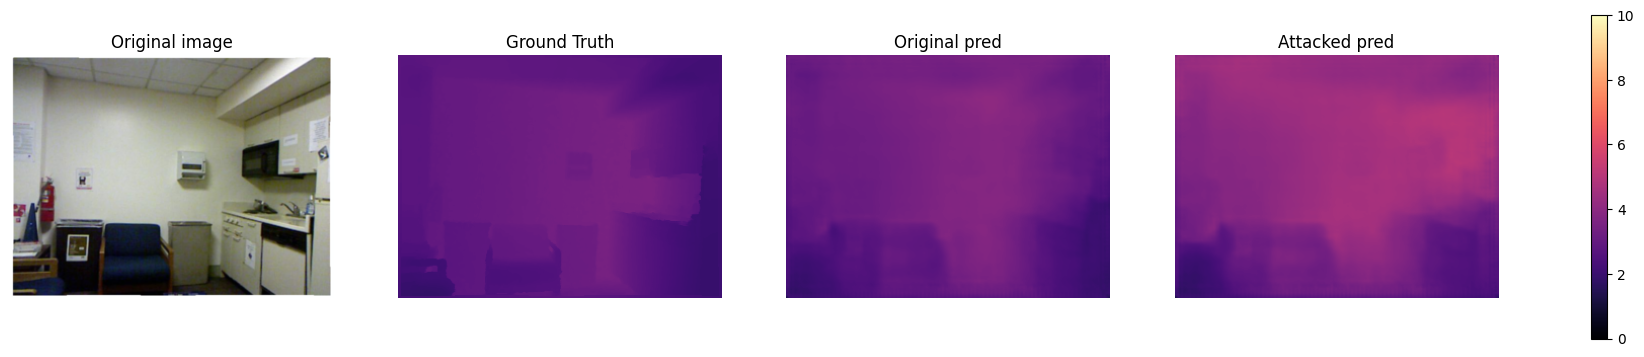

In [12]:
params_fgsm = {'epsilon': 0.02}
evaluate_attack(model, test_loader, CONFIG['DEVICE'], 'fgsm', params_fgsm)

Evaluating Attack PGD ({'epsilon': 0.07, 'alpha': 0.015, 'num_iter': 10}):   0%|          | 0/41 [00:00<?, ?it…

Evaluation attack PGD ({'epsilon': 0.07, 'alpha': 0.015, 'num_iter': 10})
           | original images | attacked images
-------------------------------------------------
MAE        | 0.4667          | 2.0165
RMSE       | 0.7054          | 2.4432


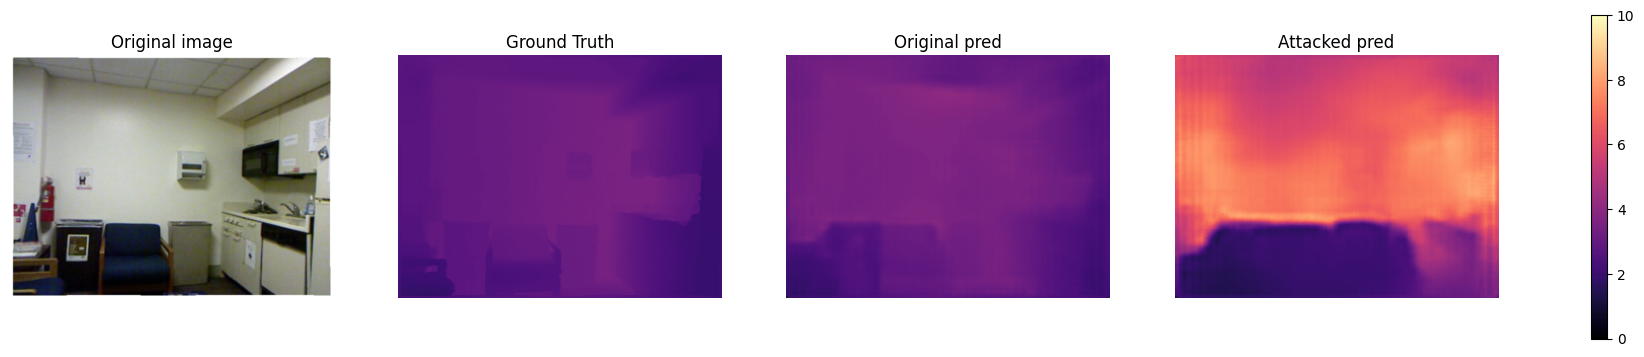

In [34]:
params_pgd = {'epsilon': 0.07, 'alpha': 0.015, 'num_iter': 10}
evaluate_attack(model, test_loader, CONFIG['DEVICE'], 'pgd', params_pgd)

Evaluating Attack GNP ({'sigma': 0.2}):   0%|          | 0/41 [00:00<?, ?it/s]

Evaluation attack GNP ({'sigma': 0.2})
           | original images | attacked images
-------------------------------------------------
MAE        | 0.4667          | 0.6963
RMSE       | 0.7054          | 1.0139


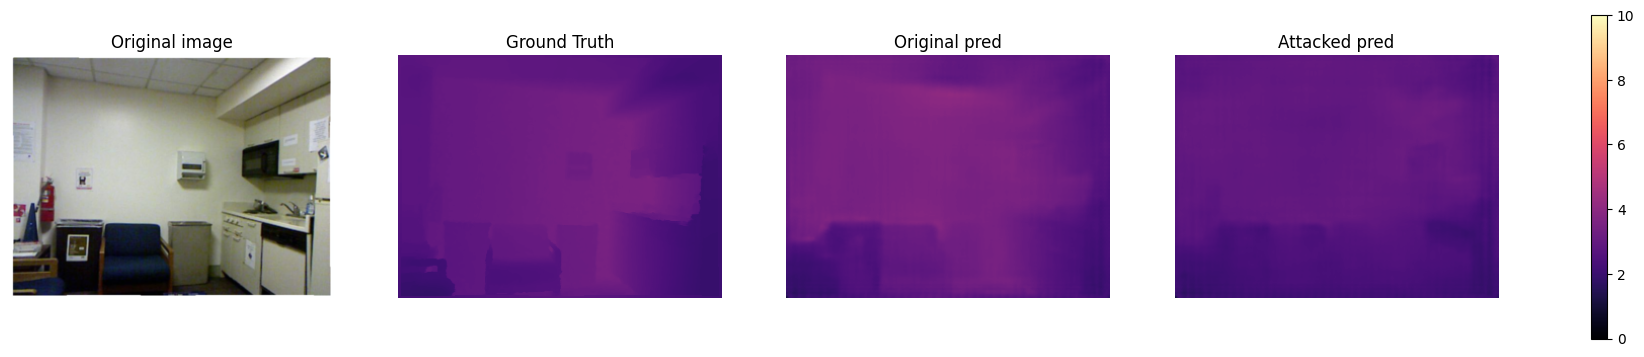

In [38]:
params_gnp = {'sigma': 0.2}
evaluate_attack(model, test_loader, CONFIG['DEVICE'], 'gnp', params_gnp)